# Gaussian Mixture Model:
A Gaussian Mixture Model (GMM) is a probabilistic model that assumes data points are generated from a mixture of several Gaussian (normal) distributions with unknown parameters. Unlike hard clustering methods such as K-Means which assign each point to a single cluster based on the closest centroid, GMM performs soft clustering by assigning each point a probability of belonging to multiple clusters.

# Expectation-Maximization (EM) Algorithm:
To fit a Gaussian Mixture Model to the data we use the Expectation-Maximization (EM) algorithm which is an iterative method that optimize the parameters of the Gaussian distributions like mean, covariance and mixing coefficients. It works in two main steps:

# (1)Expectation Step (E-step):
In this step the algorithm calculates the probability that each data point belongs to each cluster based on the current parameter estimates (mean, covariance, mixing coefficients).
# (2)Maximization Step (M-step): 
After estimating the probabilities the algorithm updates the parameters (mean, covariance and mixing coefficients) to better fit the data.

# Akaike Information Criterion (AIC)
AIC is a model selection criterion developed by Hirotugu Akaike that aims to estimate the relative quality of different models while penalizing for model complexity.The purpose of AIC is to find a model that maximizes the likelihood of the data while taking into account the number of parameters used.

# Bayesian Information Criterion (BIC)
Similar to AIC, the Bayesian Information Criterion (BIC) is another model selection criterion that considers both model fit and complexity. BIC is based on Bayesian principles and provides a more stronger penalty for model complexity compared to AIC.


In [11]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
#==================================================================================================================================================================================================
wine = load_wine()
X = wine.data
y_true = wine.target # true labels, only for validation
#==================================================================================================================================================================================================

In [12]:
print(X[:5])
#==================================================================================================================================================================================================

[[1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
  2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 1.120e+01 1.000e+02 2.650e+00 2.760e+00
  2.600e-01 1.280e+00 4.380e+00 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 1.860e+01 1.010e+02 2.800e+00 3.240e+00
  3.000e-01 2.810e+00 5.680e+00 1.030e+00 3.170e+00 1.185e+03]
 [1.437e+01 1.950e+00 2.500e+00 1.680e+01 1.130e+02 3.850e+00 3.490e+00
  2.400e-01 2.180e+00 7.800e+00 8.600e-01 3.450e+00 1.480e+03]
 [1.324e+01 2.590e+00 2.870e+00 2.100e+01 1.180e+02 2.800e+00 2.690e+00
  3.900e-01 1.820e+00 4.320e+00 1.040e+00 2.930e+00 7.350e+02]]


In [13]:
import pandas as pd
#==================================================================================================================================================================================================
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y_true = wine.target  

print(X.head())
print("\nShape of dataset:", X.shape)
#==================================================================================================================================================================================================

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  
0                  

In [14]:
# Standardize features
#==================================================================================================================================================================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#==================================================================================================================================================================================================


In [15]:
import numpy as np
from scipy.stats import multivariate_normal
#==================================================================================================================================================================================================
class GMM_Scratch:
    def __init__(self, n_components=3, max_iters=100, tol=1e-4, random_state=42):
        self.K = n_components
        self.max_iters = max_iters
        self.tol = tol
        np.random.seed(random_state)
    #==============================================================================================================================================================================================
    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        # Randomly pick K data points as initial means
        rand_idx = np.random.choice(n_samples, self.K, replace=False)
        self.means = X[rand_idx]
        # Initialize covariances as identity matrices
        self.covs = np.array([np.cov(X, rowvar=False) for _ in range(self.K)])
        # Equal mixing coefficients
        self.weights = np.ones(self.K) / self.K
    #==============================================================================================================================================================================================
    def e_step(self, X):
        n_samples = X.shape[0]
        resp = np.zeros((n_samples, self.K))
        
        for k in range(self.K):
            resp[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covs[k])
        
        # Normalize responsibilities
        resp_sum = resp.sum(axis=1, keepdims=True)
        resp_sum[resp_sum == 0] = 1e-10  # prevent division by zero
        resp /= resp_sum
        return resp
    #==============================================================================================================================================================================================
    def m_step(self, X, resp):
        n_samples, n_features = X.shape
        Nk = resp.sum(axis=0)
        
        # Update weights
        self.weights = Nk / n_samples
        
        # Update means
        self.means = (resp.T @ X) / Nk[:, np.newaxis]
        
        # Update covariances
        self.covs = np.zeros((self.K, n_features, n_features))
        for k in range(self.K):
            diff = X - self.means[k]
            self.covs[k] = (resp[:, k][:, np.newaxis] * diff).T @ diff / Nk[k]
            # Add small value to diagonal to prevent singularity
            self.covs[k] += 1e-6 * np.eye(n_features)
    #==============================================================================================================================================================================================
    def compute_log_likelihood(self, X):
        n_samples = X.shape[0]
        log_likelihood = 0
        for i in range(n_samples):
            p = 0
            for k in range(self.K):
                p += self.weights[k] * multivariate_normal.pdf(X[i], mean=self.means[k], cov=self.covs[k])
            log_likelihood += np.log(p + 1e-10)
        return log_likelihood
    #==============================================================================================================================================================================================
    def fit(self, X):
        self.initialize_parameters(X)
        self.log_likelihoods = []
        
        for iteration in range(self.max_iters):
            resp = self.e_step(X)
            self.m_step(X, resp)
            
            log_likelihood = self.compute_log_likelihood(X)
            self.log_likelihoods.append(log_likelihood)
            
            if iteration > 0 and abs(self.log_likelihoods[-1] - self.log_likelihoods[-2]) < self.tol:
                print(f"Converged at iteration {iteration}")
                break
    #==============================================================================================================================================================================================
    def predict(self, X):
        resp = self.e_step(X)
        return np.argmax(resp, axis=1)
    #==============================================================================================================================================================================================
    def bic(self, X):
        n_samples, n_features = X.shape
        n_params = self.K * n_features * (n_features + 1) / 2 + self.K * n_features + (self.K - 1)
        log_likelihood = self.compute_log_likelihood(X)
        return -2 * log_likelihood + n_params * np.log(n_samples)
    #==============================================================================================================================================================================================
    def aic(self, X):
        n_samples, n_features = X.shape
        n_params = self.K * n_features * (n_features + 1) / 2 + self.K * n_features + (self.K - 1)
        log_likelihood = self.compute_log_likelihood(X)
        return -2 * log_likelihood + 2 * n_params
#==================================================================================================================================================================================================

In [16]:

# Fit GMM
#==================================================================================================================================================================================================
gmm = GMM_Scratch(n_components=3, max_iters=100, tol=1e-4)
gmm.fit(X_scaled)

labels = gmm.predict(X_scaled)
#==================================================================================================================================================================================================


Converged at iteration 64


In [17]:
# Evaluate
#==================================================================================================================================================================================================
sil = silhouette_score(X_scaled, labels)
ari = adjusted_rand_score(y_true, labels)

print(f"Silhouette Score: {sil:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"BIC: {gmm.bic(X_scaled):.4f}")
print(f"AIC: {gmm.aic(X_scaled):.4f}")
#==================================================================================================================================================================================================

Silhouette Score: 0.1371
Adjusted Rand Index: 0.3198
BIC: 5988.0208
AIC: 4988.9408


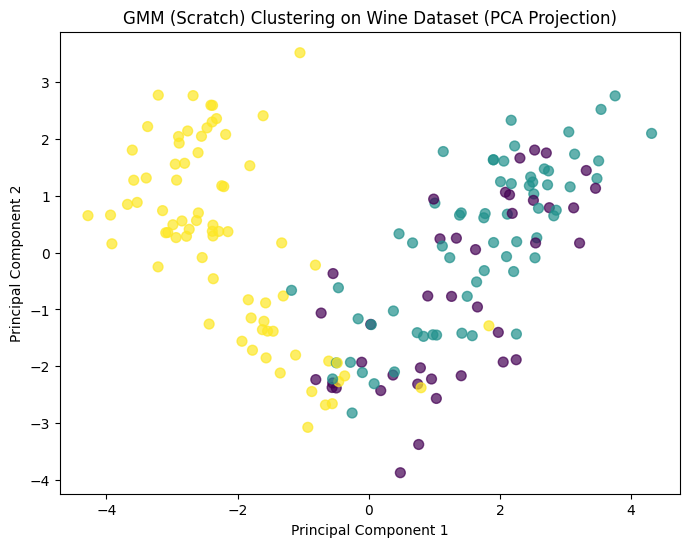

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#==================================================================================================================================================================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
#==================================================================================================================================================================================================
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.title("GMM (Scratch) Clustering on Wine Dataset (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()
#==================================================================================================================================================================================================

In [19]:
#📊 Evaluation Metrics

#Metric	                                                  Description

#Silhouette Score:	                                       Measures cluster separation and cohesion. Higher = better.
#BIC/AIC:	                                               Penalize model complexity. Lower = better model fit.
#ARI (Optional):	                                       Measures how well predicted clusters match true classes.
